In [2]:
import pathlib
import sys
from typing import Optional
import warnings

path = pathlib.Path().resolve().parent
sys.path.insert(0, str(path))

import numpy as np
import matplotlib.pyplot as plt

from src.mixture_fit import fits, fits_baes, sum_exp
from src.data_loading import load_data
from src.bootstrapping import bootstrap, final_guess

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

%matplotlib widget

In [3]:
def robustness(fun_name: str,
              mode: str = 'simulate',
              bs_num: int = 100,
              comp_num: int = 1,
              log: bool = True,
              save_path: Optional[str] = None,
              *args, **kwargs):
    """
    Testing procedure for robustness of the estimator.

    Parameters
    -----------
    fun_name: str
        The estimator to be used in the testing procedure.
        'WLS' for Weighted least squares,
        'MAP' for Maximum a posteriori estimator.
    mode: str = 'simulate'
        'simulate' or 'real'
        Used to define the testing mode.
         'simulate' for the stability test with different noise levels on generated data.
         'real' for parameter estimation for 5 identical experiments with 1 component.
    bs_num: int = 100
        Ignored in 'real' mode.
        Number of simulations to run for each noise level in 'simulate' mode.
    comp_num: int = 1
        Ignored in 'real' mode.
        Number of components to simulate in 'simulate' mode.
    log: bool = True
        If True prints/draws the output corresponding to the mode.
        If mode is 'simulate' draws several plots with testing results.
        If mode is 'real' prints the estimated parameters for every experiment.
    save_path: str or None = None
        Path to save the plot if mode='simulate' and log=True. If None draws the plot
        in interactive window.
    *args, **kwargs
        Used to pass arguments to fun. Avoid repetitions with robustness arguments.

    Returns
    -------
    if mode == 'simulate'
    sigma_range: np.ndarray
        Array with the values fo sgima used in robustness test.
    guessed_count: np.ndarray
        Array with length of len(sigma_range).
        Number of correctly guessed number of components.
    res: np.ndarray
        Array with shape of (len(sigma_range), num_comp).
        Shows the mean value of the correctly guessed components for each sigma.
    res_std: np.ndarray
        Array with shape of (len(sigma_range), num_comp).
        Shows the STD value of the correctly guessed components for each sigma.

    if mode == 'real'
    results: np.ndarray
        Array of estimation results for each of 5 experiments. Each element of array
        is an array of results of estimation with different number of components.
    guesses: np.ndarray
        Array with the optimal estimation results for each of 5 experiments. Each 
        element consists of (optimal index, optimal parameters, std of optimal parameters).
        Optimal parameters are calculated with the final_guess function. 
    """
    if fun_name == 'WLS':
        fun = fits
    elif fun_name == 'MAP':
        fun = fits_baes
    else:
        raise ValueError('fun_name must be "WLS" or "MAP".')
    if mode == 'simulate':
        if comp_num > 4:
            raise ValueError('Current state of method only supports simmulation for up to 4 components')
        D_coeff = np.array([0.306, 0.463, 0.694, 1.042])[:comp_num]
        w_coeff = 1 / comp_num

        parameters = np.zeros(2 * comp_num)
        parameters[1::2] = D_coeff
        parameters[::2] = w_coeff
        folder = pathlib.Path(path,'data', 'R2_5times')
        data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-1.txt')
        x, _ = load_data(data_path)
        y_model = sum_exp(parameters, x)

        res, res_std, guessed_count = [], [], []
        stacked_res_array = []
        sigma_range = np.geomspace(2e-3, 2e-1, 15)
        for calc_sigma in tqdm(sigma_range, total=len(sigma_range)):
            try:
                result, optim_res = bootstrap(fun, x, y_model, calc_sigma, bs_num, show_progress=False, *args, **kwargs)
                correct_guess = (optim_res[:, 0] == comp_num-1)
                if correct_guess.sum() == 0:
                    correct_mean = np.zeros(comp_num * 2)
                    correct_std = np.zeros(comp_num * 2)
                    stacked_res_array.append(np.zeros((bs_num, comp_num * 2))) 
                else:
                    stacked_res = np.vstack(optim_res[:, 1][correct_guess])
                    correct_mean = stacked_res.mean(0)
                    correct_std = stacked_res.std(0)
                    stacked_res_array.append(stacked_res)
            except ValueError:
                correct_guess = np.array([0])
                correct_mean = np.zeros(comp_num * 2)
                correct_std = np.zeros(comp_num * 2)
                stacked_res_array.append(np.zeros((bs_num, comp_num * 2))) 
            guessed_count.append(correct_guess.sum())
            res.append(correct_mean)
            res_std.append(correct_std)
        
        guessed_count = np.array(guessed_count)
        res = np.vstack(res)
        res_std = np.vstack(res_std)
        stacked_res_array = np.array(stacked_res_array)

        if log:
            plt.close('all')
            plt.figure(figsize=(14, 4))
            plt.subplot(1, 3, 1)
            plt.plot(sigma_range, guessed_count)
            plt.ylim(-bs_num*0.05, 1.05*bs_num)
            plt.title('Number of correct guesses')
            plt.xscale('log')
            for i in range(comp_num):
                plt.subplot(comp_num, 3, 2 + 3 * i)
                plt.xscale('log')
                plt.hlines(parameters[2 * i], sigma_range[0], sigma_range[-1])
                plt.errorbar(sigma_range, res[:, 2 * i], res_std[:, 2 * i], fmt='.', c='blue')
                plt.ylim(-0.1, 1.1)
                
                plt.subplot(comp_num, 3, 3 + 3 * i)
                plt.xscale('log')
                plt.hlines(parameters[2 * i + 1], sigma_range[0], sigma_range[-1])
                plt.errorbar(sigma_range, res[:, 2 * i+1], res_std[:, 2 * i+1], fmt='.', c='blue')
                plt.ylim(-0.1, 1.1)
                for idx in range(15):
                    points_num = len(stacked_res_array[idx])
                    plt.subplot(comp_num, 3, 2 + 3 * i)
                    plt.scatter([sigma_range[idx]] * points_num, stacked_res_array[idx][:, 2 * i], c='lightblue', alpha=0.5)

                    plt.subplot(comp_num, 3, 3 + 3 * i)
                    plt.scatter([sigma_range[idx]] * points_num, stacked_res_array[idx][:,2 * i + 1], c='lightblue', alpha=0.5)
            plt.subplot(comp_num, 3, 2)
            plt.title('w coefficients')
            plt.subplot(comp_num, 3, 3)
            plt.title('D coefficients')
            plt.tight_layout()
            if save_path is not None:
                plt.savefig(save_path, dpi=300)
            else:
                plt.show()
        
        return sigma_range, guessed_count, res, res_std

    elif mode == 'real':
        results = []
        y_arr = [] 
        for i in range(5):
            folder = pathlib.Path(path,'data', 'R2_5times')
            data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-{i + 1}.txt')
            x, y = load_data(data_path)
            y_arr.append(y)

            res = fun(x, y, *args, **kwargs)
            results.append(res)
        y_arr = np.vstack(y_arr)
        sigma = y_arr.std(0)
        sigma[0] = sigma[1]
        results = np.vstack(results)
        results_std = ((results - results.mean(0)) ** 2).mean(0) ** 0.5
        
        guesses = []
        correct_idx = []
        for i in range(5):
            guess = final_guess(x, y, sigma, results[i], results_std)
            guesses.append(guess)
            if guess[0] == 0:
                correct_idx.append(i)
            if log:
                print(f'Guessed number of components = {guess[0] + 1}, params = {guess[1]}')
        guesses = np.array(guesses)
        if log:
            print(f'Correctly guesses {len(correct_idx)}/5')
            stacked = np.vstack(guesses[correct_idx])
            stacked_mean = stacked[:, 1].mean(0)
            stacked_std = ((stacked[:, 1] - stacked_mean.reshape(-1, 1)) ** 2).mean() ** 0.5
            print(f'w = {stacked_mean[0]:.4f} ± {stacked_std[0]:.4f}')
            print(f'D = {stacked_mean[1]:.4f} ± {stacked_std[1]:.4f}')   
        return results, guesses
            
    else:
        raise ValueError('Mode must be "simulate" or "real"!')

  0%|          | 0/15 [00:00<?, ?it/s]

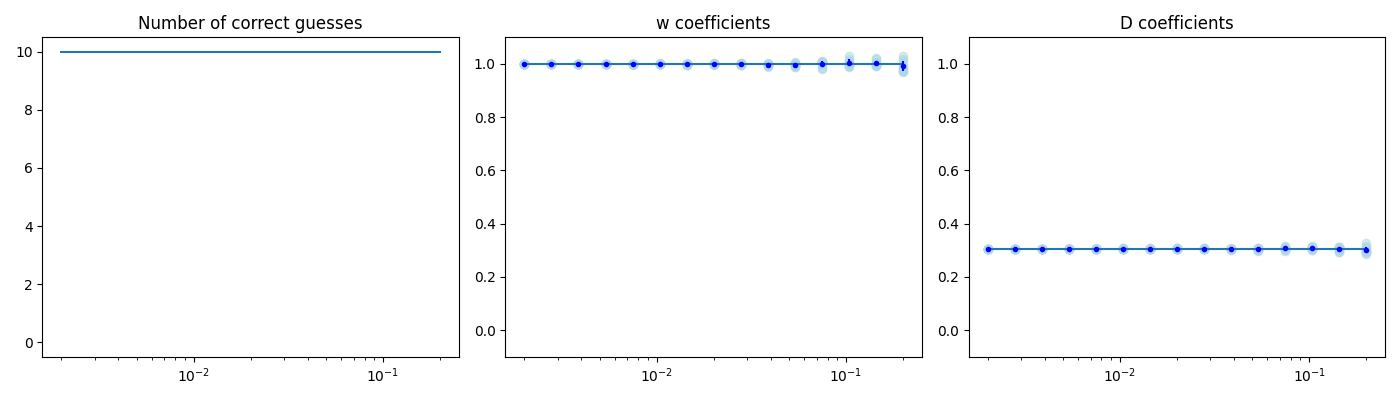

In [4]:
sigma_range, guessed_count, res, res_std = robustness('WLS', comp_num=1, bs_num=10, log=True, method='BFGS', sigma=0.018, reg=1.3)

In [3]:
results, guesses = robustness('WLS', mode='real', log=True, method='BFGS', sigma=0.018, reg=1.3)

Guessed number of components = 1, params = [0.98419209 1.10042641]
Guessed number of components = 1, params = [1.00498066 1.09069289]
Guessed number of components = 1, params = [0.98168052 1.09044247]
Guessed number of components = 1, params = [0.99396429 1.11401465]
Guessed number of components = 1, params = [0.98065056 1.11081407]
Correctly guesses 5/5
w = 0.9891 ± 0.0799
D = 1.1013 ± 0.0799
